# Case Study 1: Educational Outcomes for Hearing-impaired Children

In [1]:
# Import data analysis packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import pymc modules
import arviz as av
import pymc as pm

Here, we are interested in determining factors associated with
better or poorer learning outcomes.

## The Data

The anonymized dataset is taken from the Listening and
Spoken Language Data Repository (LSL-DR), an international data repository.

The anonymized data set tracks the demographics and longitudinal
outcomes for children who have hearing loss and are enrolled in
programs focused on supporting listening and spoken language
development. Researchers are interested in discovering factors
related to improvements in educational outcomes within these programs.

The data set contains a suite of available predictors including:

- Gender (`male`)
- Number of household siblings (`siblings`)
- Index of family involvement (`family_inv`)
- Whether the primary household language is not English (`non_english`)
- Presence of a previous disability (`prev_disab`)
- Non-white race (`non_white`)
- Age at time of testing (in months, `age_test`)
- Whether hearing loss is not severe (`non_severe_hl`)
- Whether the subject's mother obtained a high school diploma or better (`mother_hs`)
- Whether the hearing impairment was identified by 3 months of age (`early_ident`)

The outcome variable is a standardized test score in one of several
learning domains.

In [3]:
# Load the test scores to be analyzed.
test_scores = pd.read_csv(pm.get_data('test_scores.csv'), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


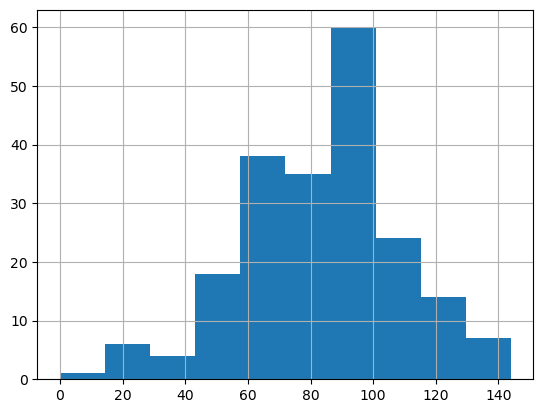

In [4]:
# Examine a histogram of the outcomes
test_scores['score'].hist()

plt.show()

In [5]:
# Dropping missing values is, generally, a **very bad idea**. We do so
# in this case for simplicity. Additionally, we convert all values to
# floating point numbers.
X = test_scores.dropna().astype(float)

# The `DataFrame.pop()` method drops the specified item from the
# `DataFrame` and returns the dropped items.
y = X.pop('score')

# Standardize the features
X -= X.mean() # Centered at the mean
X /= X.std() # Normalize to the standard deviation

# I'm uncertain. What do `N` and `D` stand for?
N, D = X.shape
N, D

(101, 10)

## The Model

This problem is a more realistic problem than our introductory
linear regression problem. Specifically,

- The problem is a **multivariate** regression problem
- We do not know, _a priori_, which parameters are
  relevant for constructing a statistical model.

A number of approaches are available for solving the second issue;
however, we will use _regularization_, a popular automated approach
that penalizes ineffective co-variates by shrinking them toward zero
if they do not contribute toward predicting outcomes.

In a Bayesian context, instead of using methods like lasso or
ridge regression, we apply an appropriate **prior** to the
regression coefficients. One such prior is the _hierarchical
regularized horseshoe_. This prior uses **two** regularization
strategies:

- One global
- A set of local parameters - one for each coefficient

The key to making this work is by selecting a [long-tailed
distribution](https://en.wikipedia.org/wiki/Long_tail)
as the shrinkage priors. This approach allows some priors(?)
to be non-zero while pushing the rest toward zero.

The horseshoe prior for each regression coefficient, $\beta_{i}$,
looks like:

$$
\beta_{i} \sim \mathcal{N} ( 0, \tau^{2} \cdot \widetilde{\lambda}_{i}^{2})
$$

where $\sigma$ is the prior on the error standard deviation that
will also be used for the model likelihood.

In this expression, $\tau$ is the global shrinkage parameter and
$\widetilde{\lambda}_{i}$ is the local shrinkage parameter.



Let's start global. For the prior on $\tau$, we will use the
Half-StudentT distribution. This choice is reasonable because
it is heavy tailed.

$$
\tau \sim Half-StudentT_{2}(\frac{D_{0}}{D - D_{0}} \cdot \frac{\sigma}{\sqrt N})
$$

One catch: our parameterization of the prior requires a constant,
$D_{0}$, which represents the true number of non-zero parameters.
Fortunately, we only need a reasonable guess and it only need to
be within an order of magnitude of the true number. We'll use
half the number of predictors as our guess:

In [7]:
D0 = int(D / 2)

The local shrinkage parameters are defined by the ratio

$$
\widetilde{\lambda}_{i}^{2} = \frac{c^{2} \lambda_{i}^{2}}{c^{2} + \tau^{2} \lambda_{i}^{2}}
$$

To complete this specification, we need priors on
$\lambda_{i}$ and $c$. Similar to the global shrinkage, we use
a long-tailed Half-StudentT on the $\lambda_{i}$. We need $c^{2}$
to be strictly positive but not necessarily long-tailed.
Consequently, we will use an inverse gamma prior on $c^{2}$
where $c^{2} \sim InverseGamma(1, 1)$.

Finally, to allow the NUTS sampler to sample the $\beta_{i}$
more efficiently, we will **re-parameterize** as follows:

$$
\begin{gather}
z_{i} \sim \mathcal{N}(0, 1) \\
\beta_{i} = z_{i} \cdot \tau \cdot \widetilde{\lambda}_{i}
\end{gather}
$$

You will often encounter this re-parameterization in practice.

### Model Specification

Specifying the model in PyMC mirrors its statistical specification.
This model employs a couple of new distributions: the
[HalfStudentT](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.HalfStudentT.html#pymc.HalfStudentT)
distribution for the $\tau$ and $\lambda$ priors, and the
[InverseGamma](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.InverseGamma.html#pymc.InverseGamma)
distribution for the $c^2$ variable.

In PyMC, variables with purely positive values like
[InverseGamma](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.InverseGamma.html#pymc.InverseGamma)
are transformed with a log transform. This transformation makes
sampling more robust. Behind the scenes, a variable in the
unconstrained unconstrained space (named `<variable-name>_log`)
is added to the model for sampling. Variables with priors that
constrain them on two sides, like
[Beta](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Beta.html#pymc.Beta)
or
[Uniform](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Uniform.html#pymc.Uniform),
are also transformed to be unconstrained but with a
log odds transform.

We are also going to take advantage of named dimensions in
PyMC and ArviZ by passing input variable names into the model as
coordinates called "predictors." This implementation allows us
to pass this vector of names as a replacement for the `shape`
integer argument in the vector-valued parameters. The model
will then associate the appropriate name for each latent
parameter that it is estimating. This implementation is a little
more work to set up, but will pay dividends later when we are
working with our model output.

Let's encode this model in PyMC.

In [8]:
import pytensor.tensor as pt

with pm.Model(coords={'predictors': X.columns.values}) as test_score_model:
    # Prior on error standard deviation
    sigma = pm.HalfNormal('sigma', 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT('tau', 2, D0 / (D - D0) * sigma / pt.sqrt(N))

    # Local shrinkage prior
    lam = pm.HalfStudentT('lam', 5, dims='predictors')
    c2 = pm.InverseGamma('c2', 1, 1)
    z = pm.Normal('z', 0.0, 1.0, dims='predictors')

    # Shrunken coefficients
    beta = pm.Deterministic(
        'beta',
        z * tau * lam * pt.sqrt(c2 / (c2 * tau**2 * lam**2)),
        dims='predictors'
    )

    # No shrinkage on intercept
    beta0 = pm.Normal('beta0', 100, 25.0)

    scores = pm.Normal('scores', beta0 + pt.dot(X.values, beta), sigma,
                       observed=y.values)

Notice that we have wrapped the calculation of `beta` in a
`Deterministic` PyMC class. You can read more about this
implementation in detail below, but this wrapping ensures
that the values of this deterministic variable is retained
in e sample trace.

Also note that we have declared the `Model` name `test_score_model`
in the first occurrence of the context manager, rather than
splitting it into two lines, as we did for the first example.

Once the model is complete, we can look at its structure using
GraphViz, which plots the model graph. It's useful to ensure that
the relationships in the model you have coded are correct, as it's
easy to make a coding mistake.


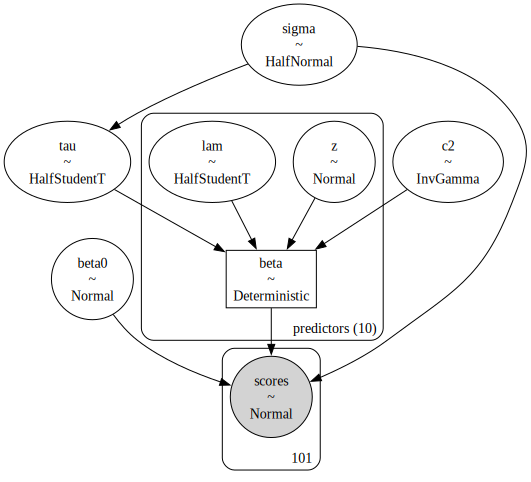

In [9]:
 pm.model_to_graphviz(test_score_model)